In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import partridge as ptg

%matplotlib inline

In [2]:
path = 'data/TriMet-2018-02-06.zip'
route_short_name = '20'
direction_id = '0'
start_time = 0*60*60 # 3pm
end_time = 30*60*60   # 7pm

KM_CONVERSION = 0.0003048 # ft->km

In [3]:
date, service_ids = ptg.read_busiest_date(path)

feed = ptg.get_filtered_feed(path, {
    'trips.txt': {
        'service_id': service_ids,
        'direction_id': direction_id,
    },
    'routes.txt': {
        'route_short_name': route_short_name,
    },
})

date, service_ids

(datetime.date(2018, 6, 1),
 frozenset({'7.504', 'A.504', 'D.504', 'P.504', 'W.504'}))

In [4]:
feed.routes

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url,route_color,route_text_color,route_sort_order
14,20,TRIMET,20,Burnside/Stark,3,http://trimet.org//schedules/r020.htm,NaN,NaN,2600


In [5]:
window_idx = (feed.stop_times.arrival_time >= start_time) & (feed.stop_times.arrival_time < end_time)
stop_times = feed.stop_times[window_idx].sort_values('stop_sequence')

stop_names = dict(feed.stops[['stop_id', 'stop_name']].as_matrix())

In [6]:
patterns = set()
timepoints = set()
distances = defaultdict(list)

for trip_id, stimes in stop_times.groupby('trip_id'):
    patterns.add(tuple(stimes.stop_id))
    timepoints |= set(stimes[stimes.timepoint==1].stop_id)
    timepoints.add(stimes.stop_id.values[0])
    timepoints.add(stimes.stop_id.values[-1])
    for _, stime in stimes.iterrows():
        distances[stime.stop_id].append(stime.shape_dist_traveled)

patterns = list(patterns)

metapattern = nx.DiGraph()
for pattern in patterns:
    for a, b in zip(pattern[:-1], pattern[1:]):
        metapattern.add_edge(a, b)

Yticks = []
Ylabels = []
for stop_id in nx.topological_sort(metapattern):
    if stop_id in timepoints:
        # Take the max distance for the aesthetics. 
        dist = max(distances[stop_id]) * KM_CONVERSION
        Yticks.append(dist)
        Ylabels.append(f'{stop_names[stop_id]} ({round(dist, 1)}km)')

Yticks[0] = min(Yticks)
Yticks[-1] = max(Yticks)

print(len(patterns))

3


In [7]:
colors = list(plt.get_cmap('tab10').colors)

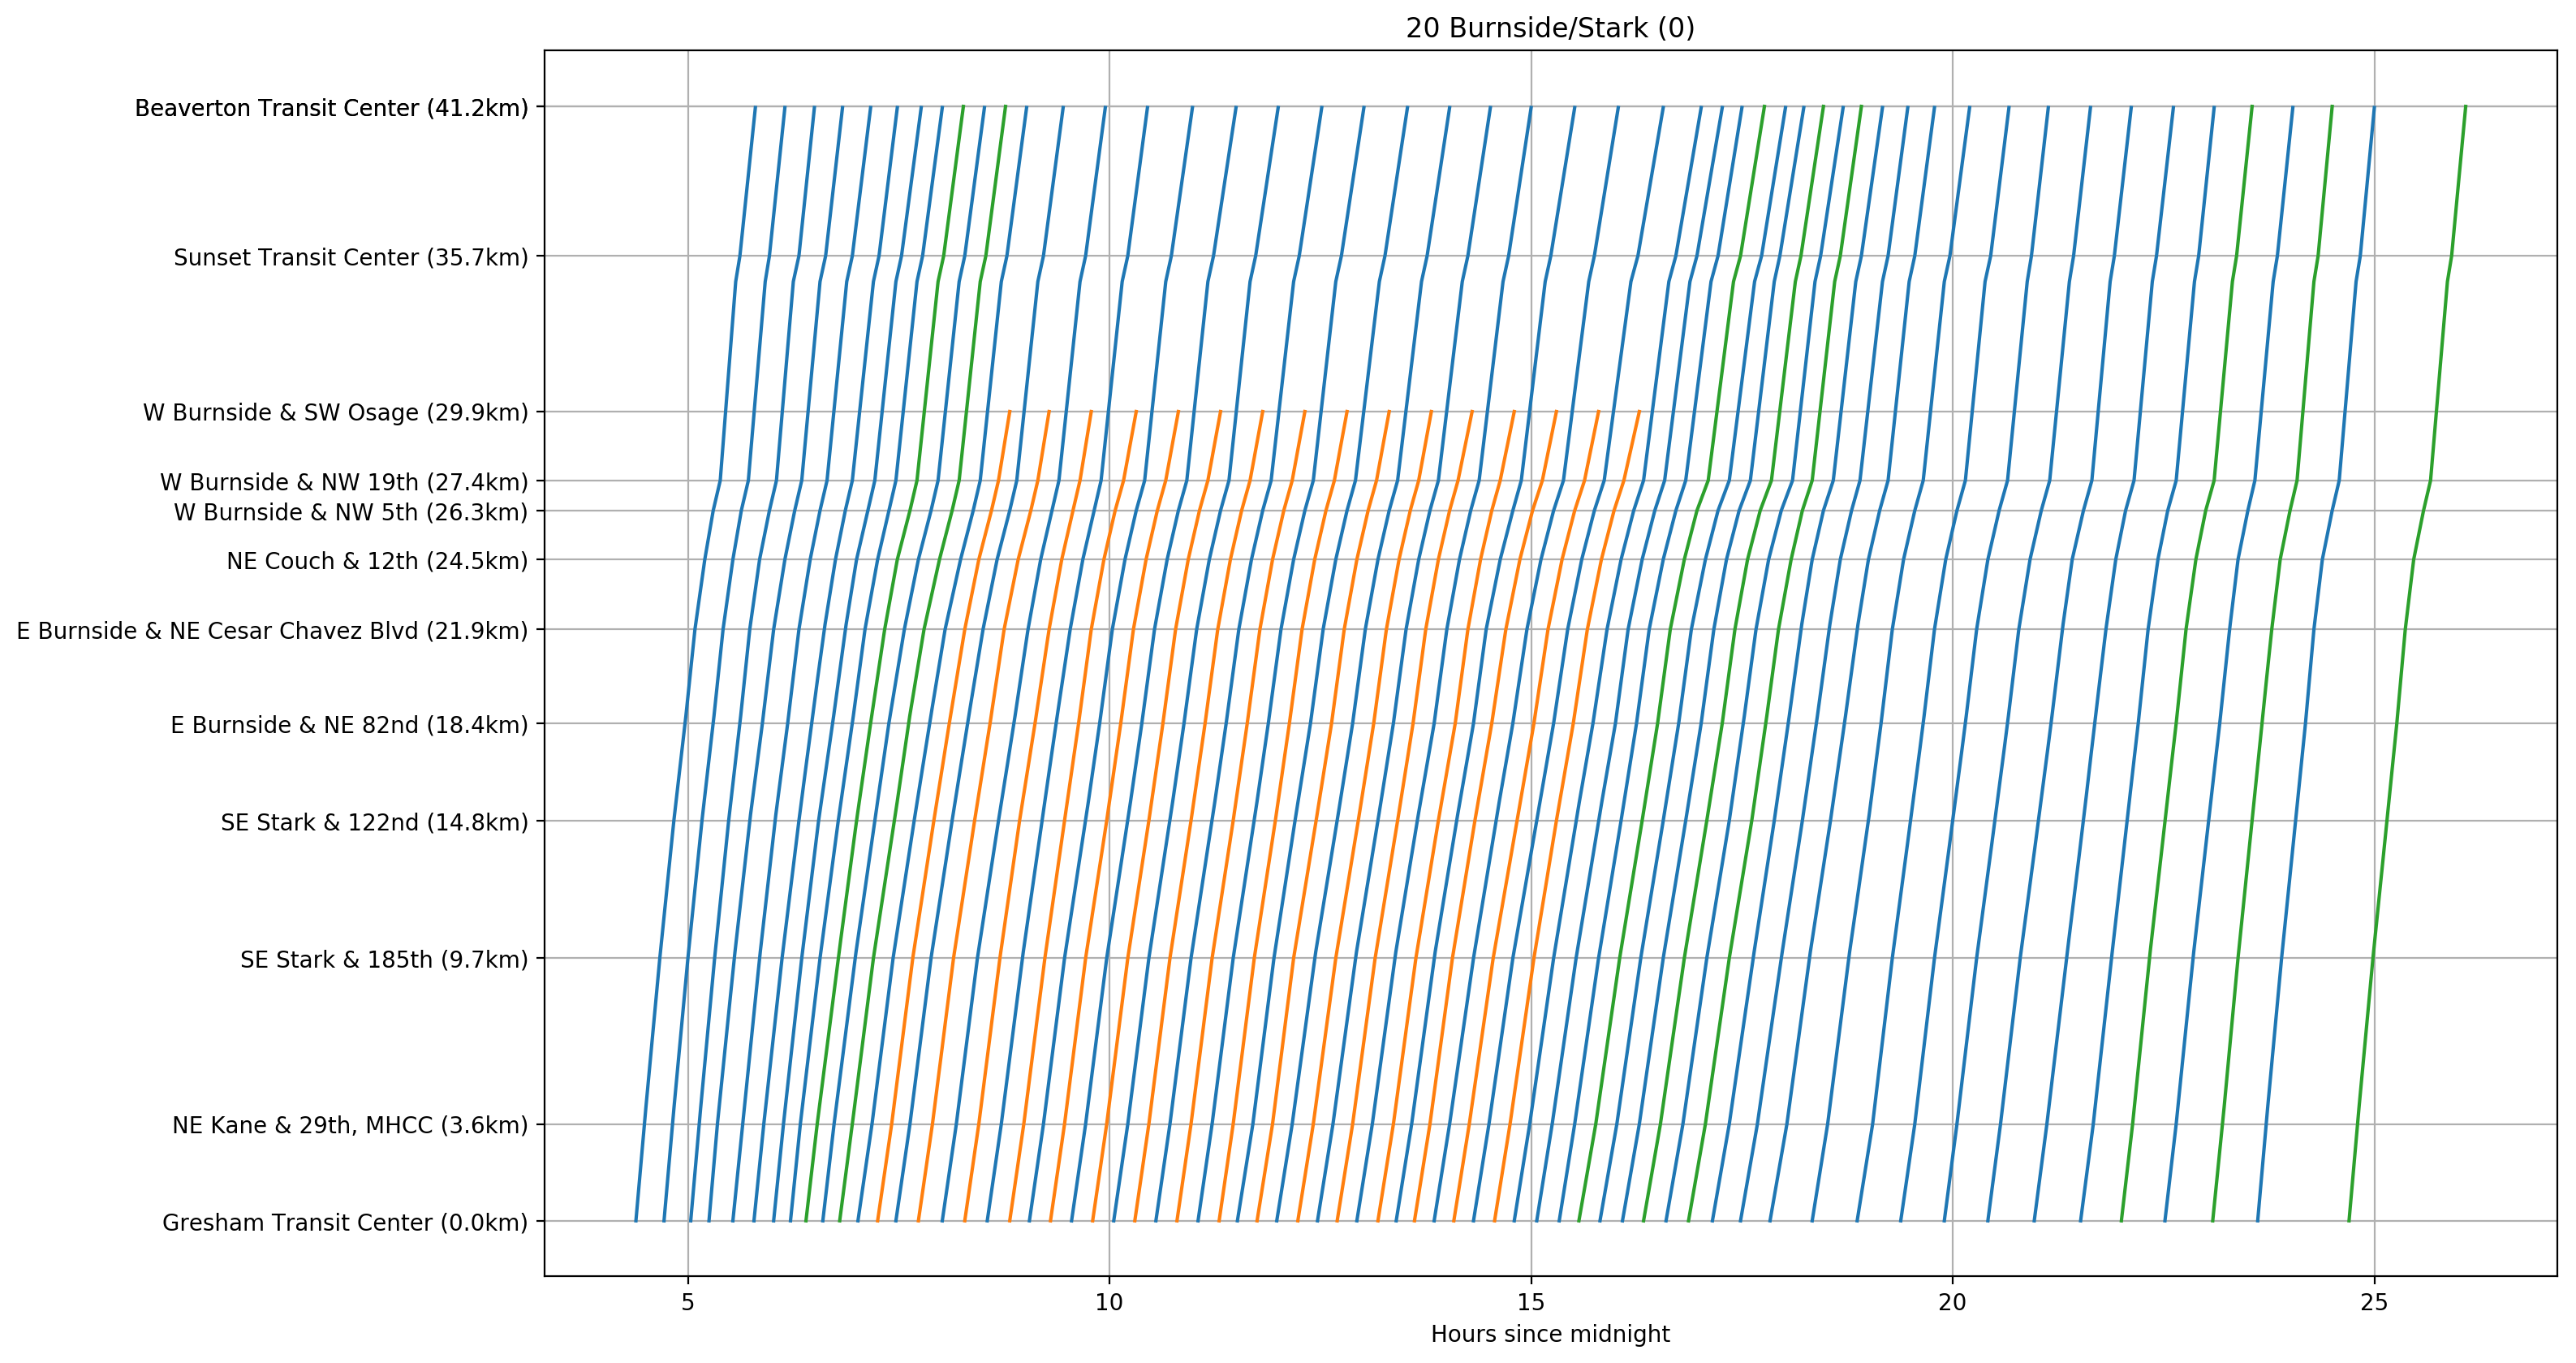

In [8]:
fig = plt.figure(figsize=(16, 10), dpi=200)
ax = fig.add_subplot(111)

for trip_id, stimes in stop_times.groupby('trip_id'):
    arrival_time = stimes.arrival_time / 60. / 60.
    shape_dist_traveled = stimes.shape_dist_traveled * KM_CONVERSION
    pattern = tuple(stimes.stop_id)
    color = colors[patterns.index(pattern)]
    _ = ax.plot(arrival_time, shape_dist_traveled, color=color)

route = feed.routes.iloc[0]
rsn = route.route_short_name if route.route_short_name is not np.nan else ''
rln = route.route_long_name if route.route_long_name is not np.nan else ''

_ = plt.title(f'{rsn} {rln} ({direction_id})')
_ = plt.xlabel('Hours since midnight')
_ = plt.yticks(Yticks, Ylabels)

ax.grid(axis='both')

plt.show()